# How a  non-linear inversion should work

In [1]:
%matplotlib inline
from __future__ import print_function, division
from future.builtins import super, range
import numpy as np
import matplotlib.pyplot as plt
from fatiando import utils, mesher
from fatiando.vis import mpl
from fatiando.gravmag import talwani
import cPickle as pickle
from inversion import NonLinearMisfit
#from inversion Smoothness1D

In [2]:
class BasinPolyGrav(NonLinearMisfit):
    def __init__(self, xlim, npoints, props, top=0):
        super().__init__(nparams=npoints, 
                         config=dict(method='levmarq', 
                                     initial=np.ones(npoints)*3e3))
        self.xlim = xlim
        self.props = props
        self.top = top
        self._modelx = np.linspace(xlim[0], xlim[1], npoints + 2)[::-1]
        
    def _p2verts(self, p):
        h = self.top
        verts = np.empty((self.nparams + 2, 2))
        verts[:, 0] = self._modelx
        verts[:, 1] = np.concatenate([[h], p, [h]])
        return verts
        
    def predict(self, x, z, p=None):
        if p is None:
            p = self.p_
        verts = self._p2verts(p)
        poly = mesher.Polygon(verts, props=self.props)
        return talwani.gz(x, z, [poly])
    
    def jacobian(self, x, z, p):
        verts = self._p2verts(p)
        delta = np.array([0, 1])
        A = np.empty((x.size, self.nparams))
        for i in range(self.nparams):
            diff_verts = [verts[i + 2], verts[i + 1] - delta,
                          verts[i], verts[i + 1] + delta]
            diff = mesher.Polygon(diff_verts, self.props)
            A[:, i] = talwani.gz(x, z, [diff])/(2*delta[1])
        return A
            
    def fmt_estimate(self, p):
        return mesher.Polygon(self._p2verts(p), props=self.props)

In [3]:
# Make some synthetic data to test the inversion
# The model will be a polygon.
# Reverse x because vertices must be clockwise.
xs = np.linspace(0, 100000, 500)[::-1]
depths = (-1e-15*(xs - 50000)**4 + 8000 -
          3000*np.exp(-(xs - 70000)**2/(10000**2)))
depths -= depths.min()  # Reduce depths to zero
props = {'density': -300}
model = mesher.Polygon(np.transpose([xs, depths]), props)
x = np.linspace(0, 100000, 100)
z = -100*np.ones_like(x)
data = talwani.gz(x, z, [model])
#data = utils.contaminate(talwani.gz(x, z, [model]), 0.5, seed=0)

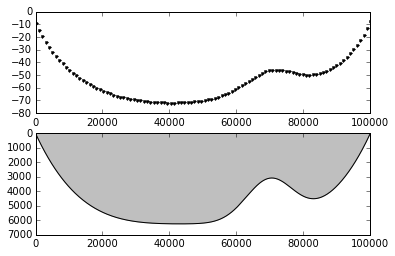

In [4]:
plt.figure()
plt.subplot(2, 1, 1)
plt.plot(x, data, '.k')
ax = plt.subplot(2, 1, 2)
mpl.polygon(model, fill='gray', alpha=0.5)
ax.invert_yaxis()

In [5]:
xlim = [x.min(), x.max()]
inv = BasinPolyGrav(xlim, npoints=300, props=model.props, top=0).fit(x, z, data)

inversion/optimization.py:112: RuntimeWarning: Exited because maximum iterations reached. Might not have achieved convergence. Try inscreasing the maximum number of iterations allowed.
  RuntimeWarning)


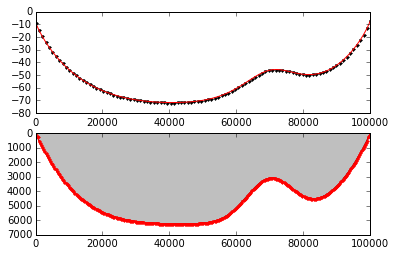

In [6]:
plt.figure()
plt.subplot(2, 1, 1)
plt.plot(x, data, '.k')
plt.plot(x, inv.predict(x, z), '-r')
ax = plt.subplot(2, 1, 2)
mpl.polygon(model, fill='gray', alpha=0.5)
mpl.polygon(inv.estimate_, style='.-r')
ax.invert_yaxis()

In [7]:
inv = pickle.loads(pickle.dumps(inv))

In [8]:
inv = BasinPolyGrav(xlim, npoints=10, props=model.props)
inv.config(method='acor', bounds=[1000, 7000]).fit(x, z, data)

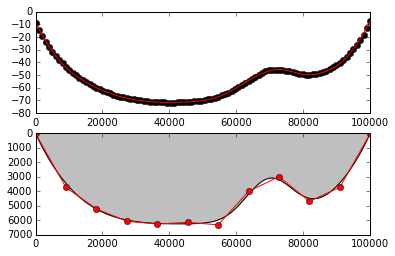

In [9]:
plt.figure()
plt.subplot(2, 1, 1)
plt.plot(x, data, 'ok')
plt.plot(x, inv.predict(x, z), '-r')
ax = plt.subplot(2, 1, 2)
mpl.polygon(model, fill='gray', alpha=0.5)
mpl.polygon(inv.estimate_, style='o-r')
ax.invert_yaxis()

# Profiling

In [10]:
%prun -T prof.txt -s tottime -q BasinPolyGrav(xlim, npoints=300, props=model.props, top=0).fit(x, z, data)
!head -n 30 prof.txt

 
*** Profile printout saved to text file u'prof.txt'. 
         188707 function calls in 5.361 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     9031    4.901    0.001    4.991    0.001 talwani.py:29(gz)
       30    0.158    0.005    4.237    0.141 <ipython-input-2-dc4ac73d02f9>:25(jacobian)
    11403    0.040    0.000    0.040    0.000 {numpy.core.multiarray.array}
       30    0.031    0.001    0.033    0.001 linalg.py:296(solve)
     9181    0.021    0.000    0.021    0.000 {numpy.core.multiarray.zeros}
     9031    0.021    0.000    0.082    0.000 mesher.py:105(__init__)
     9031    0.019    0.000    0.057    0.000 numeric.py:81(zeros_like)
       91    0.016    0.000    0.016    0.000 {numpy.core._dotblas.dot}
     9031    0.014    0.000    0.014    0.000 mesher.py:48(__init__)
     9031    0.011    0.000    0.013    0.000 mesher.py:117(x)
     9031    0.011    0.000    0.011    0.000 {numpy.core.multiarray.empty

# Regularization

In [ ]:
noisy = utils.contaminate(data, 0.5, seed=0)
M = 200
reg = BasinPolyGrav(xlim, npoints=M, props=model.props) + 1e-4*Smoothness1D(M)
reg.fit(x, z, data)

In [ ]:
plt.figure()
plt.subplot(2, 1, 1)
plt.plot(x, noisy, 'ok')
plt.plot(x, reg.predict(x, z), '-r')
ax = plt.subplot(2, 1, 2)
mpl.polygon(model, fill='gray', alpha=0.5)
mpl.polygon(reg.estimate_, style='o-r')
ax.invert_yaxis()